<a href="https://colab.research.google.com/github/wileyloyd/wileyloyd.github.io/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

# Loading packages

## Install packages on restart

In [1]:
#!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
from keras.layers import LSTM, Dropout, Dense, Embedding, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re
from statistics import mean, median
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load the data

In [3]:
amazon = pd.read_csv('/content/drive/MyDrive/OneDrive-Personal/wgu/D213 - Advanced Data Analytics/Sentiment Analysis/sentiment_labelled_sentences/sentiment labelled sentences/amazon_cells_labelled.txt', delimiter='\t', header=None)
imdb = pd.read_csv('/content/drive/MyDrive/OneDrive-Personal/wgu/D213 - Advanced Data Analytics/Sentiment Analysis/sentiment_labelled_sentences/sentiment labelled sentences/imdb_labelled.txt', delimiter='\t', header=None)
yelp = pd.read_csv('/content/drive/MyDrive/OneDrive-Personal/wgu/D213 - Advanced Data Analytics/Sentiment Analysis/sentiment_labelled_sentences/sentiment labelled sentences/yelp_labelled.txt', delimiter='\t', header=None)

In [4]:
df = pd.concat((amazon, imdb, yelp), ignore_index=True)
df.columns = ['review', 'sentiment']
pd.set_option('display.max_colwidth', None)
df.head()

,review,sentiment
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


In [5]:
df.shape

(2748, 2)

In [6]:
df.isnull().any()

review       False
sentiment    False
dtype: bool

# Prepare the data

In [7]:
# Make all characters lowercase and remove double space characters
df['review'] = df['review'].str.lower()
df['review'] = df['review'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [8]:
df.review

0                                                           so there is no way for me to plug it in here in the us unless i go by a converter.
1                                                                                                                  good case, excellent value.
2                                                                                                                       great for the jawbone.
3                                                              tied to charger for conversations lasting more than 45 minutes.major problems!!
4                                                                                                                            the mic is great.
                                                                         ...                                                                  
2743                                                                        i think food should have flavor and texture and both were lacking.

In [9]:
df['sentiment'].value_counts()

1    1386
0    1362
Name: sentiment, dtype: int64

In [10]:
df['total_words'] = [len(x.split()) for x in df['review'].tolist()]
df['total_char'] = df['review'].apply(len)

df

,review,sentiment,total_words,total_char
0,so there is no way for me to plug it in here in the us unless i go by a converter.,0,21,82
1,"good case, excellent value.",1,4,27
2,great for the jawbone.,1,4,22
3,tied to charger for conversations lasting more than 45 minutes.major problems!!,0,11,79
4,the mic is great.,1,4,17
...,...,...,...,...
2743,i think food should have flavor and texture and both were lacking.,0,12,66
2744,appetite instantly gone.,0,3,24
2745,overall i was not impressed and would not go back.,0,10,50
2746,"the whole experience was underwhelming, and i think we'll just go to ninja sushi next time.",0,16,91


# Exploratory analysis

In [11]:
print('Average number of words per review: ', np.round(df['total_words'].mean()), '\n', 'Median number of words per review: ', df['total_words'].median())

Average number of words per review:  13.0 
 Median number of words per review:  10.0


In [12]:
print('\n', 'Max words: ', df['total_words'].max(), '\n', 'Min words: ', df['total_words'].min(), '\n', 'Range of words per review: ', df['total_words'].max() - df['total_words'].min())


 Max words:  1390 
 Min words:  1 
 Range of words per review:  1389


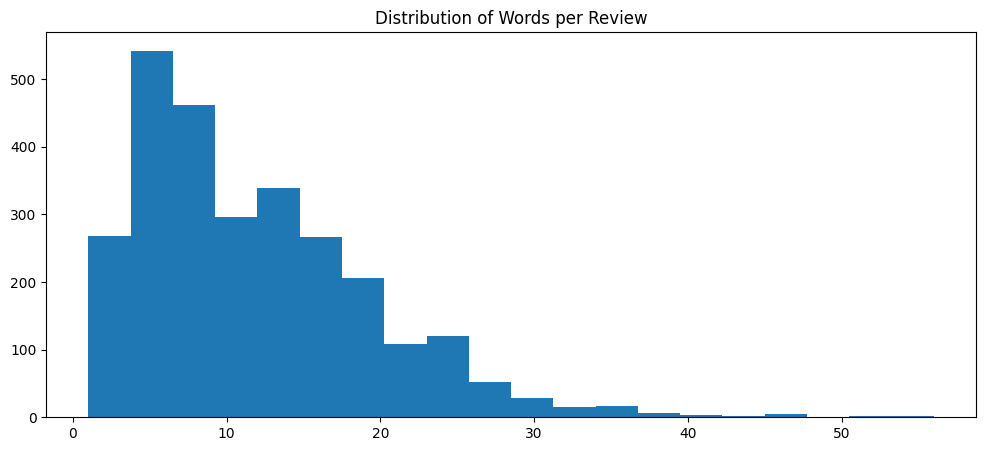

In [13]:
plt.figure(figsize=(12,5))
plt.hist(df[df['total_words'] <= 60]['total_words'], bins=20)
plt.title('Distribution of Words per Review')
plt.show()

# Apply tokenization, lemmatization, stopwords,and vectorization

In [14]:
stop_words = stopwords.words('english')

# Optional words to add to the stop words. After comparing, removing these words don't seem to have a significant impact on the model
stop_words.extend(['was', 'wa', 'u', 'go', 'hadnt', 'i', 'ha', 'would', 'even', 'one'])
stop_words.extend(['movie', 'phone', 'film', 'place', 'really', 'still', 'food'])

In [15]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    filtered_words = [word for word in lemmatized_words if word not in stop_words and word.isalpha()]
    return filtered_words

df['review'] = df['review'].apply(preprocess_text)

# Now df['review'] contains lists of lemmatized words without stopwords

vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n')
tokenizer.fit_on_texts(df['review'])
x = tokenizer.texts_to_sequences(df['review'])
print('\n', df['review'], '\n', x)


 0                                                       [way, plug, unless, converter]
1                                                       [good, case, excellent, value]
2                                                                     [great, jawbone]
3                                      [tied, charger, conversation, lasting, problem]
4                                                                         [mic, great]
                                             ...                                      
2743                                                 [think, flavor, texture, lacking]
2744                                                       [appetite, instantly, gone]
2745                                                        [overall, impressed, back]
2746               [whole, experience, underwhelming, think, ninja, sushi, next, time]
2747    [wasted, enough, life, poured, salt, wound, drawing, time, took, bring, check]
Name: review, Length: 2748, dtype: object

In [16]:
word_lengths = [len(word) for sentence in df['review'] for word in sentence]

print(sum(word_lengths))

95885


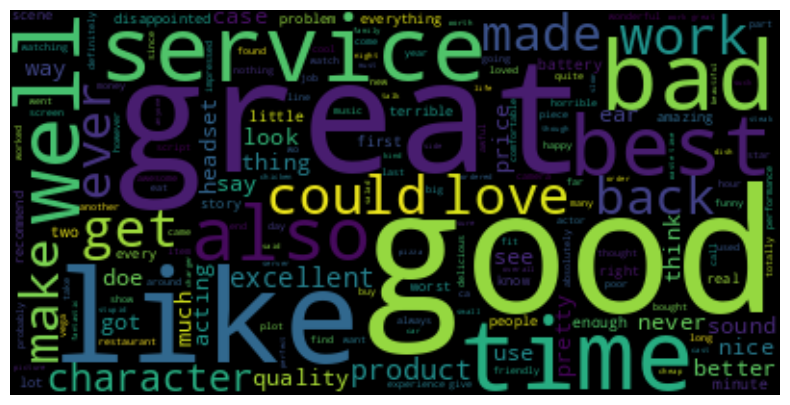

In [17]:
textt = df['review'].apply(lambda x: ' '.join(x))
textt = '\n'.join(textt)
word_cloud = WordCloud(stopwords=stop_words).generate(textt)
plt.figure(figsize=(12,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
textt

'way plug unless converter\ngood case excellent value\ngreat jawbone\ntied charger conversation lasting problem\nmic great\njiggle plug get line right get decent volume\nseveral dozen several hundred contact imagine fun sending\nrazr owner must\nneedle say wasted money\nwaste money time\nsound quality great\nimpressed going original battery extended battery\ntwo seperated mere ft started notice excessive static garbled sound headset\ngood quality though\ndesign odd ear clip comfortable\nhighly recommend blue tooth\nadvise everyone fooled\nfar good\nwork great\nclick way make wonder long mechanism last\nwent motorola website followed direction could get pair\nbought use kindle fire absolutely loved\ncommercial misleading\nyet run new battery two bar three day without charging\nbought mother problem battery\ngreat pocket pc combination\nowned month say best mobile\nthink instruction provided helpful\npeople couldnt hear talk pull earphone talk\ndoe hold charge\nsimple little use breakage

In [19]:
df['lem_words'] = df['review'].apply(lambda x: len(x))
df['lem_char'] = df['review'].apply(lambda x: len(''.join(x)))
df.head()


,review,sentiment,total_words,total_char,lem_words,lem_char
0,"[way, plug, unless, converter]",0,21,82,4,22
1,"[good, case, excellent, value]",1,4,27,4,22
2,"[great, jawbone]",1,4,22,2,12
3,"[tied, charger, conversation, lasting, problem]",0,11,79,5,37
4,"[mic, great]",1,4,17,2,8


In [20]:
df[df['lem_words'] > 100]

,review,sentiment,total_words,total_char,lem_words,lem_char
1019,"[structure, easily, tightly, constructed, history, cinema, think, something, vitally, important, occurs, every, minute, word, content, level, enough, easily, fill, dozen, anyone, right, mind, ask, anything, quite, simply, highest, superlative, form, cinema, imaginable, yes, doe, require, rather, significant, amount, piece, fit, together, create, beautiful, picture, short, certainly, pull, punch, graphic, far, best, part, game, number, best, th, game, series, deserves, strong, love, insane, game, massive, level, massive, unlockable, character, massive, game, waste, money, game, kind, money, wasted, properly, actually, graphic, good, time, today, graphic, crap, say, canada, fun, game, aye, game, rock, buy, play, enjoy, love, pure, brilliance, flick, doomed, conception, ...]",0,865,4655,367,2166
1136,"[fact, hard, remember, part, ray, charles, acted, played, man, ray, charles, legendary, ray, charles, life, provided, excellent, biographical, material, well, beyond, another, musician, hitchcock, great, director, ironically, mostly, find, total, waste, time, watch, secondly, hitchcock, pretty, much, perfected, thriller, chase, pandering, audience, sabotage, hence, whole, story, lack, certain, energy, plot, simply, rumble, like, machine, desperately, depending, addition, new, scene, usual, hitchcock, logic, flaw, mishima, extremely, uninteresting, chilly, unremarkable, author, chilly, abstruse, culture, flat, reenactment, hold, attention, emotionally, adrift, stagy, rest, sits, awful, soldier, singing, song, masculinity, pledge, hairsplitting, purity, admiration, sword, etc, bore, piece, kill, momentum, quicker, anyone, else, schrader, ...]",0,1390,7749,599,3787
1149,"[love, ending, perfect, shed, tear, thrilled, seeing, like, never, forget, cult, cult, classic, depth, character, man, underneath, malta, setting, dry, barren, dialogue, terrible, hockey, scene, terrible, defensemen, playing, like, year, old, goalie, diving, shot, foot, wide, net, etc, seen, waste, time, call, drama, ridiculous, started, watching, believe, character, particular, relationship, bakery, assistant, waitress, work, superficial, gave, feeling, watching, play, rather, character, storyline, lot, like, stage, farce, time, pyromaniac, waylaid, assistant, bored, care, happened, next, switched, glad, pay, see, laugh, smile, anything, big, yawn, good, show, watch, educational, child, year, old, barney, definitely, super, de, duper, pretty, funny, babie, bop, cute, ...]",0,302,1510,110,633
1646,"[great, sound, effect, impressive, special, effect, ca, recommend, enough, call, nut, think, best, ever, great, character, actor, telly, savalas, peter, boyle, hour, minute, sheer, tedium, melodrama, horrible, acting, mess, script, sinking, feeling, good, lord, thinking, lot, hole, script, like, bad, two, hour, tv, imagine, every, single, decision, made, wrong, dialogue, atrocious, acting, beyond, abysmal, everything, stink, trouble, writing, directing, make, impossible, establish, thing, make, watchable, like, character, story, theme, worse, incredibly, weak, thrown, follows, little, band, mansonites, reporter, working, story, anniversary, killing, dumb, pointless, complete, waste, time, short, bother, wo, spoil, ending, pretty, amazing, best, scene, end, wo, spoil, ever, ...]",1,797,4378,360,2205


In [21]:
df[df['lem_words'] < 100]['lem_words'].max()

81

In [22]:
avg_words = round(df['lem_words'].mean())
print(avg_words)

6


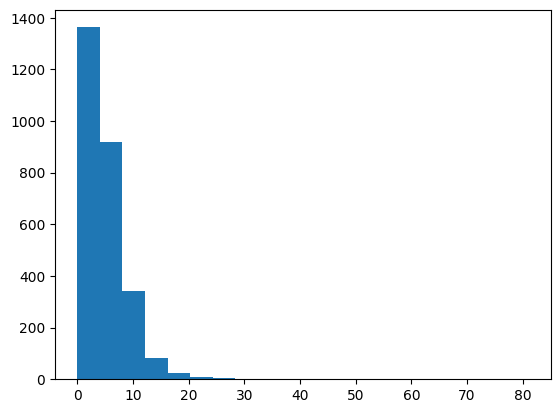

In [23]:
dfhist = df[df['lem_words'] < 100]
plt.hist(dfhist['lem_words'], bins = 20)
plt.show()

In [24]:
max_words = 25
x = pad_sequences(x, maxlen=max_words, padding='post', truncating='post')
print(x.shape)

(2748, 25)


In [25]:
x[0]

array([  32,  230,  511, 1945,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [26]:
print(tokenizer.word_index)

{'good': 1, 'great': 2, 'time': 3, 'like': 4, 'work': 5, 'service': 6, 'bad': 7, 'well': 8, 'best': 9, 'ever': 10, 'also': 11, 'back': 12, 'could': 13, 'get': 14, 'quality': 15, 'doe': 16, 'love': 17, 'make': 18, 'made': 19, 'character': 20, 'product': 21, 'headset': 22, 'excellent': 23, 'nice': 24, 'thing': 25, 'better': 26, 'never': 27, 'sound': 28, 'recommend': 29, 'much': 30, 'use': 31, 'way': 32, 'battery': 33, 'think': 34, 'first': 35, 'look': 36, 'price': 37, 'pretty': 38, 'see': 39, 'acting': 40, 'ear': 41, 'say': 42, 'got': 43, 'worst': 44, 'case': 45, 'year': 46, 'minute': 47, 'enough': 48, 'two': 49, 'little': 50, 'disappointed': 51, 'everything': 52, 'every': 53, 'right': 54, 'amazing': 55, 'scene': 56, 'waste': 57, 'going': 58, 'people': 59, 'definitely': 60, 'know': 61, 'real': 62, 'terrible': 63, 'story': 64, 'problem': 65, 'money': 66, 'lot': 67, 'experience': 68, 'new': 69, 'came': 70, 'piece': 71, 'give': 72, 'friendly': 73, 'actor': 74, 'life': 75, 'many': 76, 'resta

In [27]:
print('Distinct words: ', len(tokenizer.word_index))

Distinct words:  4443


In [28]:
df.head()

,review,sentiment,total_words,total_char,lem_words,lem_char
0,"[way, plug, unless, converter]",0,21,82,4,22
1,"[good, case, excellent, value]",1,4,27,4,22
2,"[great, jawbone]",1,4,22,2,12
3,"[tied, charger, conversation, lasting, problem]",0,11,79,5,37
4,"[mic, great]",1,4,17,2,8


# Splitting the data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, df['sentiment'], test_size=.10, random_state = 96)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.10, random_state = 96)

In [31]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [32]:
# There are an evenly distributed number of positive and negative reviews in the training data.
y_train.value_counts()

1    1139
0    1086
Name: sentiment, dtype: int64

In [33]:
X_train.shape

(2225, 25, 1)

In [34]:
x_df = pd.DataFrame(x)

# Convert df['sentiment'] to a DataFrame with one column
df_sentiment = df['sentiment'].to_frame()

# Concatenate x_df and df_sentiment along the columns axis
prepared_dataset = pd.concat([x_df, df_sentiment], axis=1)

# Now, resulting_dataset will have a shape of (2748, 26)
print(prepared_dataset.shape)

(2748, 26)


In [35]:
prepared_dataset.to_csv('/content/drive/MyDrive/OneDrive-Personal/wgu/D213 - Advanced Data Analytics/Sentiment Analysis/prepared_dataset.csv')

# Building the model

In [36]:
embed_size = 128

In [37]:
model = Sequential()

In [38]:
model.add(Embedding(vocab_size, embed_size, input_shape = (X_train.shape[1],)))
model.add(LSTM(units=100, activation = 'tanh', return_sequences=True))
model.add(Dense(units = 60, activation = 'tanh'))
model.add(GlobalAveragePooling1D())
# model.add(Dense(units = 30, activation = 'tanh'))
# model.add(Dropout(.50))
model.add(Dense(units=1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 128)           6400000   
                                                                 
 lstm (LSTM)                 (None, 25, 100)           91600     
                                                                 
 dense (Dense)               (None, 25, 60)            6060      
                                                                 
 global_average_pooling1d (  (None, 60)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 6497721 (24.79 MB)
Trainable params: 6497721 (24.79 MB)
Non-trainable params: 0 (0.00 Byte)
________________

# Running the model

In [40]:
early_stop = EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), callbacks=early_stop)

Epoch 1/10
18/18 [==============================] - 6s 201ms/step - loss: 0.6918 - accuracy: 0.5236 - val_loss: 0.6878 - val_accuracy: 0.5927
Epoch 2/10
18/18 [==============================] - 3s 193ms/step - loss: 0.5238 - accuracy: 0.7452 - val_loss: 0.6773 - val_accuracy: 0.7339
Epoch 3/10
18/18 [==============================] - 5s 250ms/step - loss: 0.2188 - accuracy: 0.9213 - val_loss: 0.4791 - val_accuracy: 0.7984
Epoch 4/10
18/18 [==============================] - 3s 158ms/step - loss: 0.1168 - accuracy: 0.9596 - val_loss: 0.5869 - val_accuracy: 0.7944
Epoch 5/10
18/18 [==============================] - 3s 180ms/step - loss: 0.0766 - accuracy: 0.9771 - val_loss: 0.7946 - val_accuracy: 0.7581


# Evaluating the model

In [41]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 12ms/step - loss: 0.5822 - accuracy: 0.7673


[0.5822067260742188, 0.7672727108001709]

In [42]:
history.history

{'loss': [0.6917910575866699,
  0.5238480567932129,
  0.21882036328315735,
  0.1167900338768959,
  0.07662710547447205],
 'accuracy': [0.5235955119132996,
  0.7451685667037964,
  0.9213483333587646,
  0.9595505595207214,
  0.9770786762237549],
 'val_loss': [0.6877511739730835,
  0.67726069688797,
  0.4790552854537964,
  0.5869181156158447,
  0.7946380972862244],
 'val_accuracy': [0.5927419066429138,
  0.7338709831237793,
  0.7983871102333069,
  0.7943548560142517,
  0.7580645084381104]}

## Visualizing model accuracy and loss

In [43]:
epochs = len(history.history['loss'])

In [44]:
def plot_lc(history, epochs):
  # plot the accuracy
  er = range(1, epochs+1)
  plt.figure(figsize=(12,5))
  plt.plot(er, history.history['accuracy'])
  plt.plot(er, history.history['val_accuracy'])
  plt.title('Recurrent Neural Network Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
  plt.show()

  # plot the loss
  plt.figure(figsize=(12,5))
  plt.plot(er, history.history['loss'])
  plt.plot(er, history.history['val_loss'])
  plt.title('Recurrent Neural Network Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
  plt.show()

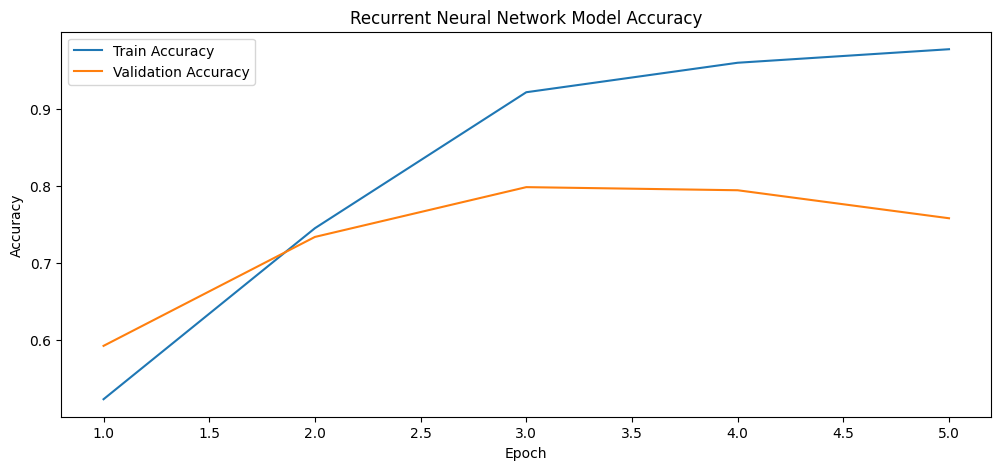

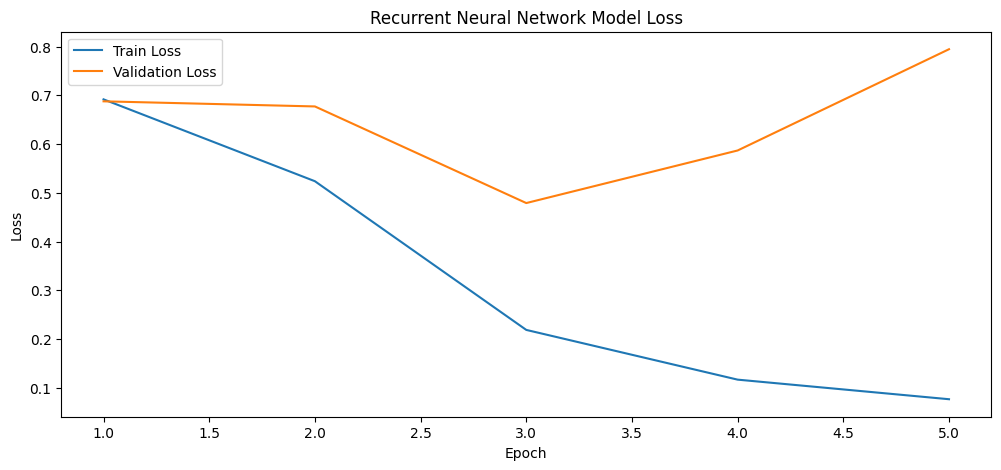

In [45]:
plot_lc(history, epochs)


In [46]:
y_pred = model.predict(X_test)
# y_pred = y_pred.round().astype(int)

9/9 [==============================] - 1s 13ms/step


## Confusion matrix

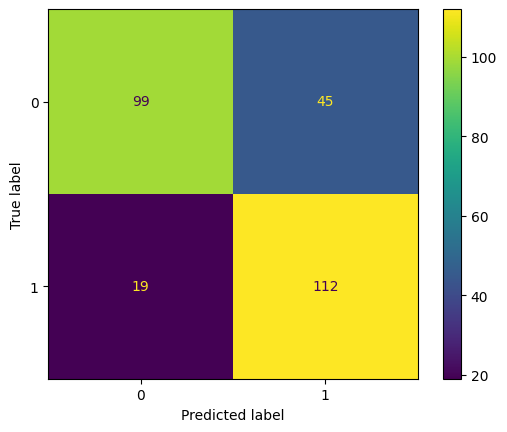

In [47]:
y_pred_classes = np.round(y_pred).astype(int)
y_test_classes = np.array(y_test).astype(int)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
cm_disp = ConfusionMatrixDisplay(conf_matrix)

cm_disp.plot()

In [48]:
model.save('/content/drive/MyDrive/OneDrive-Personal/wgu/D213 - Advanced Data Analytics/Sentiment Analysis/Customer_Review_Sentiment_Analysis.keras')